I. IMPORT LIBRARIES

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

II. LOAD THE DATASET

In [ ]:
df = pd.read_csv('D:/wavle/fraud-detect-system/backend-java/src/main/resources/mobileMoneyTransactions.csv')
df.head()

df.rename(columns={'newbalanceOrig': 'newbalanceOrg'}, inplace=True)
df.rename(columns={'nameOrig': 'nameOrg'}, inplace=True)



nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
C2030240815      2
C437804525       2
C1702844447      2
C367899282       2
C234862613       2
Name: count, Length: 459658, dtype: int64


In [4]:
col_names = df.columns
col_names

Index(['step', 'type', 'amount', 'nameOrg', 'oldbalanceOrg', 'newbalanceOrg',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrg         object 
 4   oldbalanceOrg   float64
 5   newbalanceOrg   float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


(6362620, 11)

In [6]:
# Show statistical summary of numerical features with 2 decimal rounding without scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
step,6362620.00,243.40,142.33,1.00,156.00,239.00,335.00,743.00
amount,6362620.00,179861.90,603858.23,0.00,13389.57,74871.94,208721.48,92445516.64
oldbalanceOrg,6362620.00,833883.10,2888242.67,0.00,0.00,14208.00,107315.18,59585040.37
newbalanceOrg,6362620.00,855113.67,2924048.50,0.00,0.00,0.00,144258.41,49585040.37
oldbalanceDest,6362620.00,1100701.67,3399180.11,0.00,0.00,132705.66,943036.71,356015889.35
newbalanceDest,6362620.00,1224996.40,3674128.94,0.00,0.00,214661.44,1111909.25,356179278.92
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


III. DATA EXPLORATION & PREPARATION

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0   99.8709
1    0.1291
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Systematic Flagged Transactions (isFlaggedFraud)')

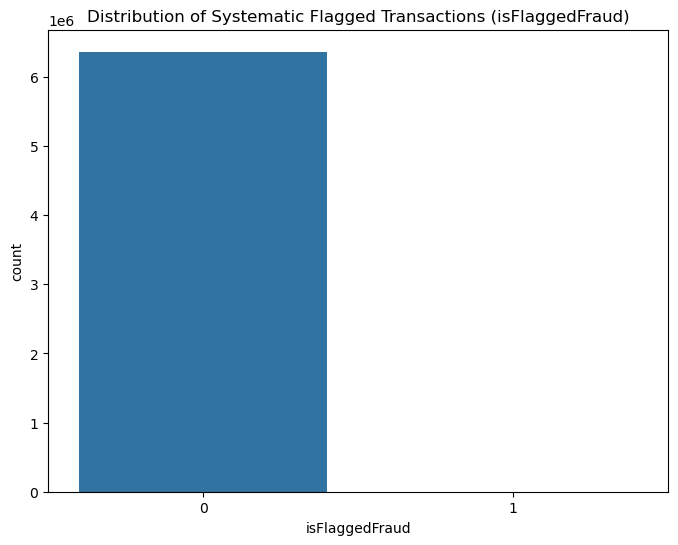

In [7]:
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print(df["isFraud"].value_counts())
print((df["isFraud"].value_counts(normalize=True)* 100).round(4))
plt.figure(figsize=(8,6))
sns.countplot(x="isFlaggedFraud", data=df)
plt.title("Distribution of Systematic Flagged Transactions (isFlaggedFraud)")

There are 6,354,407 (99,87%) legitimate transactions and 8,213 (0,13%) fraud transactions. The dataset is heavily imbalanced.

In [8]:
print(df['isFlaggedFraud'].value_counts())
(df['isFlaggedFraud'].value_counts(normalize=True) * 100).round(4)

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


isFlaggedFraud
0   99.9997
1    0.0003
Name: proportion, dtype: float64

In [9]:
print(df["type"].value_counts())

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


type
CASH_OUT   0.3517
PAYMENT    0.3381
CASH_IN    0.2199
TRANSFER   0.0838
DEBIT      0.0065
Name: proportion, dtype: float64


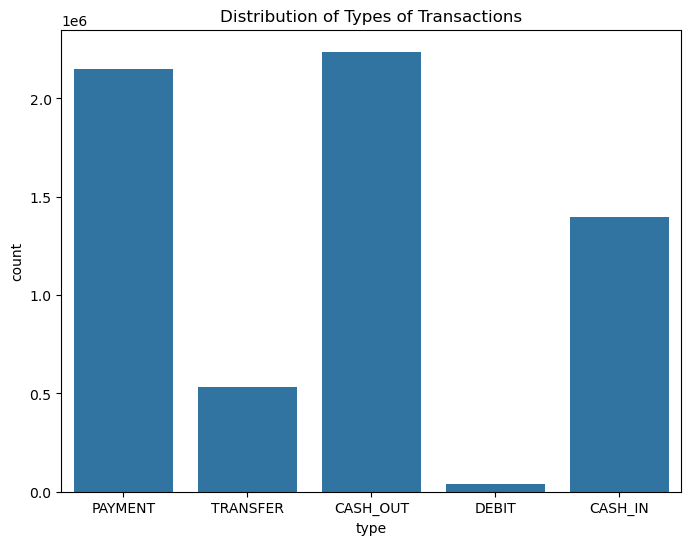

In [10]:
print(df["type"].value_counts(normalize=True))
plt.figure(figsize=(8,6))
sns.countplot(x="type", data=df)
plt.title("Distribution of Types of Transactions")
plt.show()

In [11]:
# Check the number of missing values in each column of the dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrg           0
oldbalanceOrg     0
newbalanceOrg     0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

investigate fraud vs non-fraud

In [12]:
fraud_rate = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print(fraud_rate)

type
TRANSFER   0.0077
CASH_OUT   0.0018
CASH_IN    0.0000
DEBIT      0.0000
PAYMENT    0.0000
Name: isFraud, dtype: float64


=> Only TRANSFER and CASH_OUT involves fraudulent transaction

In [13]:
# Filter only TRANSFER and CASH_OUT transactions
filtered_types = ['TRANSFER', 'CASH_OUT']
df_filtered = df[df['type'].isin(filtered_types)]

# Further filter based on fraud and type
fraud_transfer = df_filtered[(df_filtered['isFraud'] == 1) & (df_filtered['type'] == 'TRANSFER')]
fraud_cashout = df_filtered[(df_filtered['isFraud'] == 1) & (df_filtered['type'] == 'CASH_OUT')]
nonfraud_transfer = df_filtered[(df_filtered['isFraud'] == 0) & (df_filtered['type'] == 'TRANSFER')]
nonfraud_cashout = df_filtered[(df_filtered['isFraud'] == 0) & (df_filtered['type'] == 'CASH_OUT')]

In [14]:
# Fraudulent TRANSFER transactions
print("Fraudulent TRANSFER - Amount Statistics")
print(fraud_transfer['amount'].describe())
print()

# Fraudulent CASH_OUT transactions
print("Fraudulent CASH_OUT - Amount Statistics")
print(fraud_cashout['amount'].describe())
print()

# Non-Fraud TRANSFER transactions
print("Non-Fraud TRANSFER - Amount Statistics")
print(nonfraud_transfer['amount'].describe())
print()

# Non-Fraud CASH_OUT transactions
print("Non-Fraud CASH_OUT - Amount Statistics")
print(nonfraud_cashout['amount'].describe())
print()


Fraudulent TRANSFER - Amount Statistics
count       4097.0000
mean     1480891.6729
std      2414890.3787
min           63.8000
25%       128417.9600
50%       445705.7600
75%      1534985.0700
max     10000000.0000
Name: amount, dtype: float64

Fraudulent CASH_OUT - Amount Statistics
count       4116.0000
mean     1455102.5860
std      2393841.7858
min            0.0000
25%       125464.4500
50%       435516.9050
75%      1500761.0300
max     10000000.0000
Name: amount, dtype: float64

Non-Fraud TRANSFER - Amount Statistics
count     528812.0000
mean      906229.0078
std      1874155.2588
min            2.6000
25%       216570.7650
50%       486521.9100
75%       972733.6350
max     92445516.6400
Name: amount, dtype: float64

Non-Fraud CASH_OUT - Amount Statistics
count   2233384.0000
mean     173917.1558
std      131222.2410
min           0.0100
25%       72627.6900
50%      146946.5600
75%      246181.1800
max     2847566.6200
Name: amount, dtype: float64



=> Fraudulent transactions involve

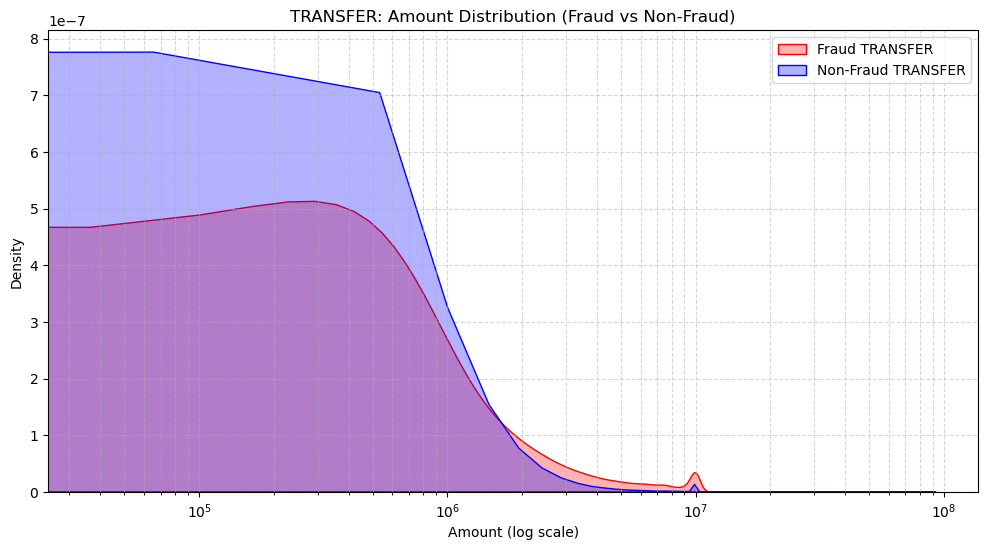

In [15]:
#Trabsfer Amount Distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(fraud_transfer['amount'], label='Fraud TRANSFER', color='red', fill=True, alpha=0.3)
sns.kdeplot(nonfraud_transfer['amount'], label='Non-Fraud TRANSFER', color='blue', fill=True, alpha=0.3)
plt.xscale('log')
plt.title('TRANSFER: Amount Distribution (Fraud vs Non-Fraud)')
plt.xlabel('Amount (log scale)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

Crossover amount where fraud density surpasses non-fraud: 1559539.47


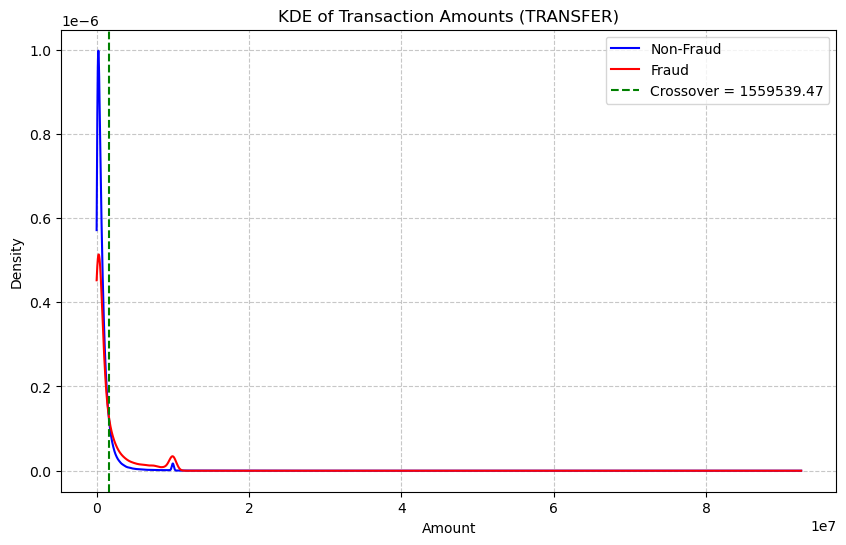

In [16]:
# Extract amount series for fraud and non-fraud for TRANSFER
fraud_transfer_amount = fraud_transfer['amount']
nonfraud_transfer_amount = df_filtered[(df_filtered['isFraud'] == 0) & (df_filtered['type'] == 'TRANSFER')]['amount']

# Compute KDEs
kde_fraud = gaussian_kde(fraud_transfer_amount)
kde_nonfraud = gaussian_kde(nonfraud_transfer_amount)

# Define x range
x_vals = np.linspace(min(fraud_transfer_amount.min(), nonfraud_transfer_amount.min()),
                     max(fraud_transfer_amount.max(), nonfraud_transfer_amount.max()), 5000)

y_fraud = kde_fraud(x_vals)
y_nonfraud = kde_nonfraud(x_vals)

# Find crossover point
intersection = None
for i in range(len(x_vals) - 1):
    if y_fraud[i] > y_nonfraud[i] and y_fraud[i-1] <= y_nonfraud[i-1]:
        # Linear interpolation for more precise crossover
        x0, x1 = x_vals[i-1], x_vals[i]
        y0_diff = y_fraud[i-1] - y_nonfraud[i-1]
        y1_diff = y_fraud[i] - y_nonfraud[i]
        slope = (y1_diff - y0_diff) / (x1 - x0)
        intersection = x0 - y0_diff / slope
        break

print(f"Crossover amount where fraud density surpasses non-fraud: {intersection:.2f}")

# Plot KDEs
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_nonfraud, label='Non-Fraud', color='blue')
plt.plot(x_vals, y_fraud, label='Fraud', color='red')

if intersection:
    plt.axvline(intersection, color='green', linestyle='--', label=f'Crossover = {intersection:.2f}')

plt.title('KDE of Transaction Amounts (TRANSFER)')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

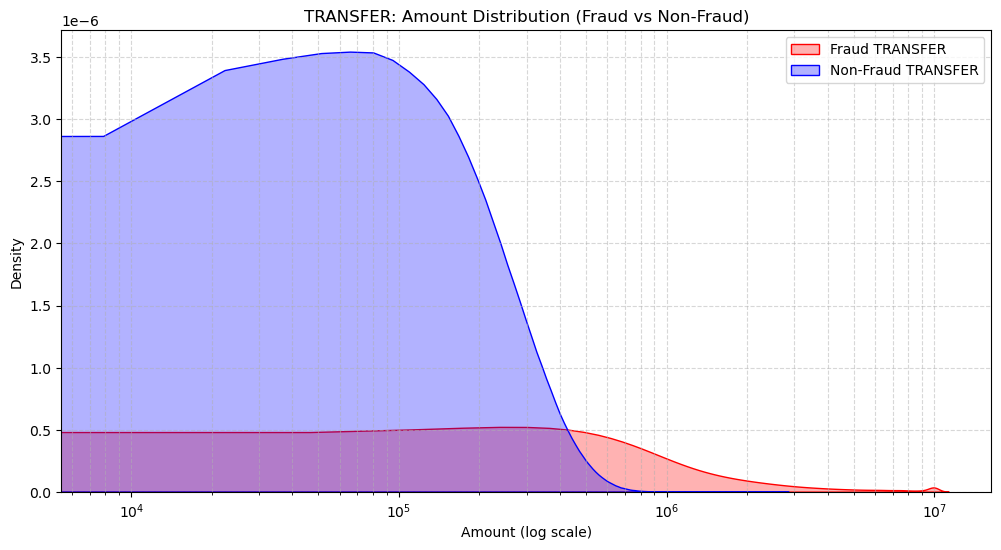

In [17]:
#CASH_OUT Amount Distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(fraud_cashout['amount'], label='Fraud TRANSFER', color='red', fill=True, alpha=0.3)
sns.kdeplot(nonfraud_cashout['amount'], label='Non-Fraud TRANSFER', color='blue', fill=True, alpha=0.3)
plt.xscale('log')
plt.title('TRANSFER: Amount Distribution (Fraud vs Non-Fraud)')
plt.xlabel('Amount (log scale)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

Crossover amount where fraud density surpasses non-fraud: 427091.58


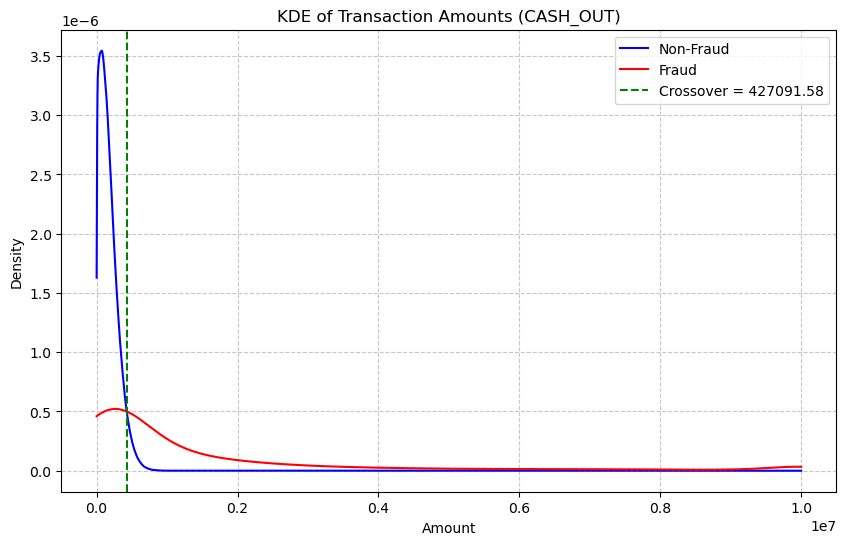

In [18]:
# Extract amount series for fraud and non-fraud for CASH_OUT
fraud_cashout_amount = fraud_cashout['amount']
nonfraud_cashout_amount = df_filtered[(df_filtered['isFraud'] == 0) & (df_filtered['type'] == 'CASH_OUT')]['amount']

# Compute KDEs
kde_fraud = gaussian_kde(fraud_cashout_amount)
kde_nonfraud = gaussian_kde(nonfraud_cashout_amount)

# Define x range
x_vals = np.linspace(min(fraud_cashout_amount.min(), nonfraud_cashout_amount.min()),
                     max(fraud_cashout_amount.max(), nonfraud_cashout_amount.max()), 5000)

y_fraud = kde_fraud(x_vals)
y_nonfraud = kde_nonfraud(x_vals)

# Find crossover point
intersection = None
for i in range(len(x_vals) - 1):
    if y_fraud[i] > y_nonfraud[i] and y_fraud[i-1] <= y_nonfraud[i-1]:
        # Linear interpolation for more precise crossover
        x0, x1 = x_vals[i-1], x_vals[i]
        y0_diff = y_fraud[i-1] - y_nonfraud[i-1]
        y1_diff = y_fraud[i] - y_nonfraud[i]
        slope = (y1_diff - y0_diff) / (x1 - x0)
        intersection = x0 - y0_diff / slope
        break

print(f"Crossover amount where fraud density surpasses non-fraud: {intersection:.2f}")

# Plot KDEs
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_nonfraud, label='Non-Fraud', color='blue')
plt.plot(x_vals, y_fraud, label='Fraud', color='red')

if intersection:
    plt.axvline(intersection, color='green', linestyle='--', label=f'Crossover = {intersection:.2f}')

plt.title('KDE of Transaction Amounts (CASH_OUT)')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [19]:
df['sender_diff'] = df['oldbalanceOrg'] - df['newbalanceOrg']
df['recipient_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

# For fraud subset
fraud_df = df[df['isFraud'] == 1]

# How many fraud transactions have sender_diff close to amount? (allow some tolerance)
tolerance = 1e-2  # adjust as needed
fraud_sender_match = (abs(fraud_df['sender_diff'] - fraud_df['amount']) < tolerance).mean()
fraud_recipient_match = (abs(fraud_df['recipient_diff'] - fraud_df['amount']) < tolerance).mean()

print(f"Fraction of fraud transactions where sender_diff ≈ amount: {fraud_sender_match:.4f}")
print(f"Fraction of fraud transactions where recipient_diff ≈ amount: {fraud_recipient_match:.4f}")


Fraction of fraud transactions where sender_diff ≈ amount: 0.9945
Fraction of fraud transactions where recipient_diff ≈ amount: 0.4377


In [20]:
tolerance = 1e-2  # tolerance for floating point equality

def analyze_balance_diffs(df, label):
    df = df.copy()
    df['sender_diff'] = df['oldbalanceOrg'] - df['newbalanceOrg']
    df['recipient_diff'] = df['newbalanceDest'] - df['oldbalanceDest']

    sender_match_frac = (abs(df['sender_diff'] - df['amount']) < tolerance).mean()
    recipient_match_frac = (abs(df['recipient_diff'] - df['amount']) < tolerance).mean()

    print(f"--- {label} ---")
    print(f"Sender diff approx amount: {sender_match_frac:.4%}")
    print(f"Recipient diff approx amount: {recipient_match_frac:.4%}")
    print(f"Sender diff stats:\n{df['sender_diff'].describe()}")
    print(f"Recipient diff stats:\n{df['recipient_diff'].describe()}")
    print("\n")

# Analyze each group
analyze_balance_diffs(fraud_transfer, "Fraudulent TRANSFER")
analyze_balance_diffs(nonfraud_transfer, "Non-Fraud TRANSFER")
analyze_balance_diffs(fraud_cashout, "Fraudulent CASH_OUT")
analyze_balance_diffs(nonfraud_cashout, "Non-Fraud CASH_OUT")

--- Fraudulent TRANSFER ---
Sender diff approx amount: 99.4874%
Recipient diff approx amount: 0.0488%
Sender diff stats:
count       4097.0000
mean     1460769.6188
std      2397947.9176
min            0.0000
25%       125464.4600
50%       438394.6700
75%      1504870.3300
max     10000000.0000
Name: sender_diff, dtype: float64
Recipient diff stats:
count      4097.0000
mean       2908.0274
std       55760.6291
min     -272024.3200
25%           0.0000
50%           0.0000
75%           0.0000
max     1933920.8000
Name: recipient_diff, dtype: float64


--- Non-Fraud TRANSFER ---
Sender diff approx amount: 3.7981%
Recipient diff approx amount: 78.1671%
Sender diff stats:
count    528812.0000
mean      33178.3854
std       87767.0889
min           0.0000
25%           0.0000
50%           0.0000
75%       22943.2500
max     4164236.3100
Name: sender_diff, dtype: float64
Recipient diff stats:
count      528812.0000
mean       994585.1115
std       2514592.8737
min      -6755513.9600
25% 

In [21]:
common_names = set(fraud_df['nameOrg']).intersection(set(fraud_df['nameDest']))
print(f"Total common names: {len(common_names)}")



Total common names: 0


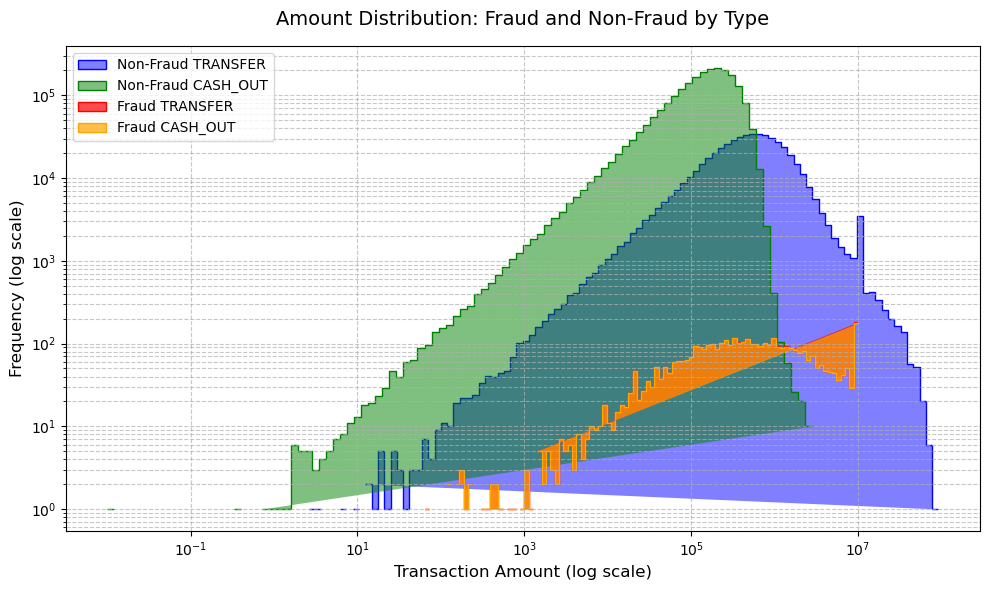

In [22]:
# Plot
plt.figure(figsize=(10,6))

# Non-Fraud curves
sns.histplot(nonfraud_transfer['amount'], bins=100, log_scale=(True, True), element='step', color='blue', label='Non-Fraud TRANSFER', alpha=0.5)
sns.histplot(nonfraud_cashout['amount'], bins=100, log_scale=(True, True), element='step', color='green', label='Non-Fraud CASH_OUT', alpha=0.5)

# Fraud curves
sns.histplot(fraud_transfer['amount'], bins=100, log_scale=(True, True), element='step', color='red', label='Fraud TRANSFER', alpha=0.7)
sns.histplot(fraud_cashout['amount'], bins=100, log_scale=(True, True), element='step', color='orange', label='Fraud CASH_OUT', alpha=0.7)

# Customize plot
plt.title("Amount Distribution: Fraud and Non-Fraud by Type", fontsize=14, pad=15)
plt.xlabel("Transaction Amount (log scale)", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [30]:
# Count destination accounts
receiver_counts = fraud_df['nameDest'].value_counts()
total_fraud_transactions = len(fraud_df)

# Filter repeated
repeated_receivers = receiver_counts[receiver_counts > 1].index
repeated_receivers_proption = len(repeated_receivers) / total_fraud_transactions

print(repeated_receivers_proption)

0.005357360282478997


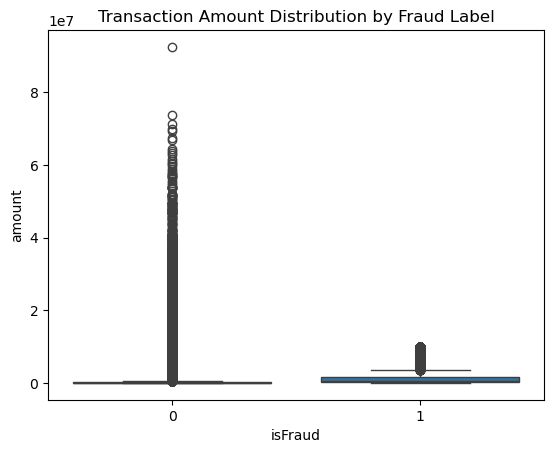

In [31]:
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Transaction Amount Distribution by Fraud Label")
plt.show()

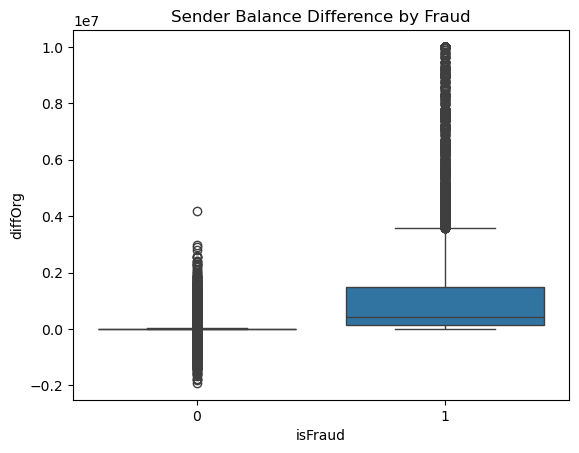

In [33]:
df['diffOrg'] = df['oldbalanceOrg'] - df['newbalanceOrg']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

sns.boxplot(x='isFraud', y='diffOrg', data=df)
plt.title("Sender Balance Difference by Fraud")
plt.show()

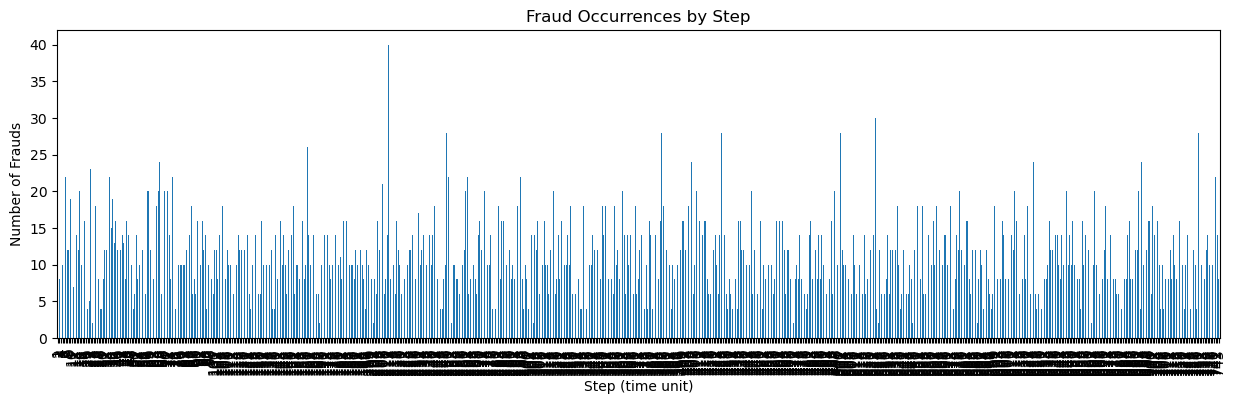

In [34]:
fraud_by_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
fraud_by_step.plot(kind='bar', figsize=(15,4))
plt.title("Fraud Occurrences by Step")
plt.xlabel("Step (time unit)")
plt.ylabel("Number of Frauds")
plt.show()

In [36]:
transfer_df = df[df['type'] == 'TRANSFER']
cashout_df = df[df['type'] == 'CASH_OUT']

common_accounts = set(transfer_df['nameOrg']) & set(cashout_df['nameOrg'])
print(f"Accounts used in both types: {len(common_accounts)}")

Accounts used in both types: 566


C:\Users\wavle\AppData\Local\Temp\ipykernel_33168\95691313.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_amount = df.groupby('amount_bin')['isFraud'].mean()


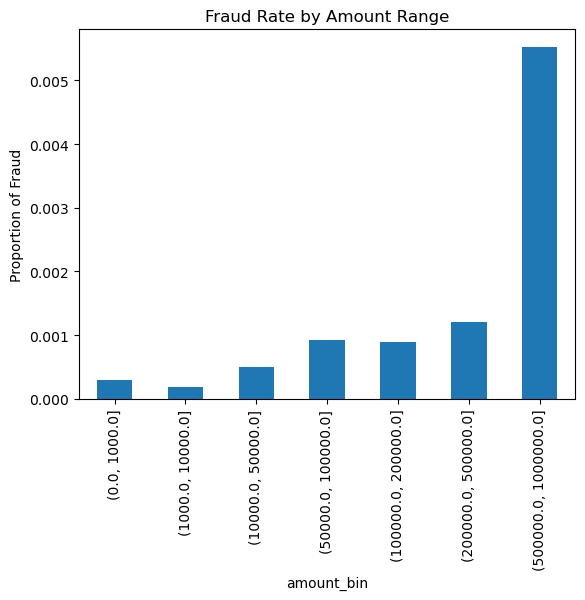

In [43]:
df['amount_bin'] = pd.cut(df['amount'], bins=[0, 1e3, 10e3, 50e3, 100e3, 200e3, 500e3, 1e6])
fraud_rate_by_amount = df.groupby('amount_bin')['isFraud'].mean()
fraud_rate_by_amount.plot(kind='bar')
plt.title("Fraud Rate by Amount Range")
plt.ylabel("Proportion of Fraud")
plt.show()